## Summary

The correlation between the dimensions decreases on applying whitening irrespective of whether the whitening parameters were derived from clean or noisy data. The amount by which reduction takes place depends on the distribution from which the parameters of the whitening transformation is derived.

## Libraries uses

* **scipy** for loading the contents of the audio file
* **numpy** for numerical computations
* **matplotlib** for plotting the data

In [1]:
# Importing the required libraries
 
import numpy as np
from scipy.io import wavfile
import scipy.io
import matplotlib.pyplot as plt

In [2]:
# Reading the audio file and printing out some important information
sample_rate, wav_file = wavfile.read("clean.wav")
print("Sampling frequency = " + str(sample_rate)) 
print("Total Number of Samples = " + str(len(wav_file)))
length = len(wav_file)/sample_rate
print("Time Length of the wav file = " + str(length))

Sampling frequency = 16000
Total Number of Samples = 50000
Time Length of the wav file = 3.125


In [3]:
# Print some sample data from the wavfile
print("Sample Data from the wav file = " + str(wav_file[:123]))

Sample Data from the wav file = [-10 -12 -30 -11 -14 -21 -12 -24 -12  -5 -14   5   5  -8  -3  -1  -1   4
   9  11   7   5   2   1   1 -11   1  14  -1  -3  -1   6   1 -13  -1   0
  -6  -4  -9 -10  -8 -11 -15  -8   1  -4 -15 -11  -1  -1  -4  -3   4  -2
  -6  -4  -4   8  -1  -4   5  -3  -1  14  26   7  16  35   6  10  19  12
  25  25  20  16   9   7  15  13   2   5  19   9  -9   5  11   2  -1  -3
   1  -4  -1  -2  -2   7  -4   3  10   2  15  22  13  17  19  16  22  32
  35  33  40  31  20  23  25  24  23  31  37  29  17  26  25]


## Audio File 

The audio sample has a sampling frequency of 16000 samples per second. We have to take a window of size 25ms. The number of samples which is a present in a window can be calculated as

Number of samples in 1s = 16K 

Number of samples in 25ms = $16K * 0.025$ = $400$ samples

The shift between successive windows  = $10ms$

Number of samples to shift moving from one window to next = $16K * 0.010$ = 160 samples


#### Number of windows  

We need not consider any padding at the end so the left end of the window should move only upto $50000-400 = 49600$

We will be shifting by 160 samples each time.

The total number of windows = $\frac{49600}{160} = 310$

On accounting for the last window 
Total Number of Frames = 310 + 1 = 311

In [4]:
# Plot amplitude vs time graph of the audio signal
def plot_time_series_graph(wav_file):
    time = np.linspace(0,length,wav_file.shape[0])
    plt.plot(time, wav_file, label="channel")
    plt.xlabel("time (s)")
    plt.ylabel("Amplitude")
    plt.show()


# Function for computing the spectrogram of the audio file
# We will be performing a 256 point FFT transformation on each window 
# and retain the first 128 dimensions
# returns a spectrogram represented as a numpy array having dimensions (No_of_features, No_of_Frames )
def compute_spectrogram(wav_file):
    starting = 0
    increment = 160
    window_size = 400

    spectrogram = None
    while(starting+window_size <= len(wav_file)):
        current_window = np.array(wav_file[starting : starting + window_size])
        #Perform the required transformation
        fft_transform = np.log(np.abs(np.fft.fft(current_window,n=256)[:128].reshape(128,1)))
        if spectrogram is None:
            spectrogram = fft_transform
        else:
            spectrogram = np.append(spectrogram,fft_transform,axis = 1)
    
        starting += increment

    print(spectrogram.shape)
    return spectrogram


# Plot the spectrogram
def plot_spectrogram(spectrogram):
    time = np.linspace(0,311,num=311)
    freq = np.linspace(0,128,128)
    plt.pcolormesh(time,freq,spectrogram)
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.show()

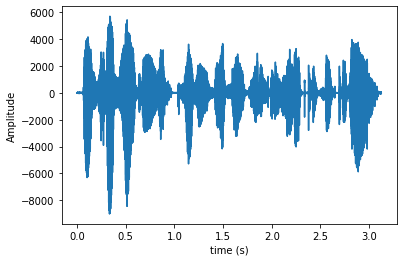

In [5]:
# Plot the time series graph of the clean wav file
plot_time_series_graph(wav_file)

(128, 311)


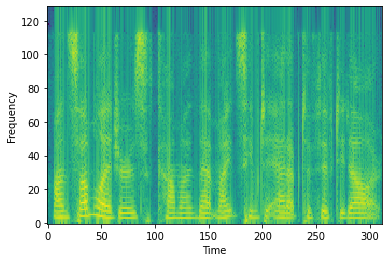

In [6]:
clean_spectrogram = compute_spectrogram(wav_file)
plot_spectrogram(clean_spectrogram)

In [7]:
class WhiteningTransform:
    
    def __init__(self):
        
        self.mean_vector = None
        self.eigen_values = None
        self.eigen_vectors = None
        
    #Computing the mean feature vector from the spectrogram   
    def compute_mean(self,spectrogram): 
        mean_vector = (np.sum(spectrogram,axis=1))*(1.0/spectrogram.shape[1])
        self.mean_vector = mean_vector.reshape((-1,1))
        return self.mean_vector
    
    # compute the mean centered data from the spectrogram.
    def compute_mean_centered_data(self,spectrogram):
        mean_centered_data = spectrogram - self.mean_vector
        return mean_centered_data
    
    # Compute the covariance matrix from the mean centered data
    def compute_covariance_matrix(self,mean_centered_data):
        N = mean_centered_data.shape[1]
        covariance_matrix = (1.0/N)*(np.matmul(mean_centered_data,mean_centered_data.transpose()))
        return covariance_matrix
    
    # compute the eigen values and eigen vectors and sort eigen vectors in decreasing order of eigen values
    def compute_eigen_values_eigen_vectors(self,covariance_matrix):
        self.eigen_values, self.eigen_vectors = np.linalg.eigh(covariance_matrix)
        
        # Sort the eigen values and vectors by decreasing eigen values
        indices = np.argsort(self.eigen_values)[::-1]
        self.eigen_values = self.eigen_values[indices]
        self.eigen_vectors = self.eigen_vectors[:,indices]
        
        print("\nLargest Eigen Value = " + str(self.eigen_values[0])) # Print the largest eigen value 
        print("\nEigen Vector corresponding to the largest eigen value\n\n" + str(self.eigen_vectors[:,1])) # The eigen vector corresponding to eigen value eigen_values[0]

        #print("\nEigen Values in Descending Order\n")
        #for i in range(len(self.eigen_values)):
        #    print(self.eigen_values[i])
        #print("\n")
        return self.eigen_values,self.eigen_vectors
    
    # Function for computing the whitened data based on the parameters derived from the base spectrogram
    def whiten_data(self,projected_data):
        diag_e = np.diag(self.eigen_values)
        diag_inverse = np.linalg.inv(diag_e)
        diag_inverse = np.sqrt(diag_inverse)
        whitened_data = np.matmul(diag_inverse,projected_data)
        return whitened_data
   
    # Project data points on to the principal components
    def project_data(self,mean_centered_data):
        return np.matmul(self.eigen_vectors.transpose(),mean_centered_data)




In [8]:
clean_whitening = WhiteningTransform()

# Compute the mean feature vector from the spectrogram corresponding to the clean audio
mean_clean_vector = clean_whitening.compute_mean(clean_spectrogram)

#Use the mean feature vector computed above to center the data on the mean vector.
mean_centered_data_clean = clean_whitening.compute_mean_centered_data(clean_spectrogram)

print("Dimension of the mean vector = " + str(mean_clean_vector.shape))
print("Mean Centered Spectrogram Dimension = " + str(mean_centered_data_clean.shape))


Dimension of the mean vector = (128, 1)
Mean Centered Spectrogram Dimension = (128, 311)


In [9]:
# Compute the covariance matrix from the mean centered data for finding the 
# eigen vectors which will be used for projection using PCA

clean_covariance_matrix = clean_whitening.compute_covariance_matrix(mean_centered_data_clean)
print(clean_covariance_matrix)


[[2.53323286 1.68776761 1.53609292 ... 1.03690451 1.05616583 1.06257165]
 [1.68776761 1.74051358 1.4870038  ... 0.99056921 0.98729779 0.98454622]
 [1.53609292 1.4870038  1.7595243  ... 1.09524559 1.09798104 1.09357328]
 ...
 [1.03690451 0.99056921 1.09524559 ... 2.32412773 2.29038811 2.30361638]
 [1.05616583 0.98729779 1.09798104 ... 2.29038811 2.28870342 2.28863241]
 [1.06257165 0.98454622 1.09357328 ... 2.30361638 2.28863241 2.32160976]]


In [10]:
# Read the eigen values and eigen vecctors sorted in decreasing order of eigen values.
e,v = clean_whitening.compute_eigen_values_eigen_vectors(clean_covariance_matrix)


Largest Eigen Value = 152.79353910129666

Eigen Vector corresponding to the largest eigen value

[ 0.06685266  0.04747596  0.0711226   0.1632158   0.10988052  0.10409735
  0.16031154  0.13212585  0.12076186  0.16457534  0.16320349  0.14934721
  0.17215689  0.15248368  0.14926329  0.15769392  0.14089378  0.14590571
  0.13908216  0.12805094  0.12822821  0.13820343  0.1201704   0.12823312
  0.13402572  0.13562456  0.11722698  0.12626519  0.11707944  0.10274546
  0.0975537   0.08808325  0.06247255  0.06617537  0.06567794  0.04616265
  0.03881396  0.04527384  0.02227102  0.03494437  0.02673781  0.02721053
  0.0337875   0.03300788  0.03523783  0.02759843  0.02318923  0.02740506
  0.02279222  0.022034    0.02151658  0.00695663  0.00378505  0.01063596
  0.00235856 -0.01212723 -0.00202    -0.00138861 -0.00538083  0.00430618
 -0.00304711 -0.00812238 -0.01781657 -0.01613993 -0.02290537 -0.01656089
 -0.03508083 -0.04760755 -0.04154825 -0.05007641 -0.04507165 -0.04868452
 -0.05734399 -0.05523462 -

In [11]:
# Project the mean centered data onto the eigen vectors which are the principcal components
projected_data = clean_whitening.project_data(mean_centered_data_clean)
print(projected_data)

[[ 3.14227484e+01  3.05567318e+01  2.95566802e+01 ...  9.74469106e+00
   2.42957939e+01  2.41687141e+01]
 [-2.07335427e+00 -7.88115935e-01 -9.98805796e-01 ...  1.78266991e+00
   2.70553995e+00 -6.06572965e-01]
 [-1.45920856e+00 -4.20032173e+00 -4.71110709e+00 ...  1.83007737e+00
  -6.14599519e+00 -2.15542359e+00]
 ...
 [ 3.75094156e-02 -2.02570782e-02 -1.24550388e-01 ...  2.96785369e-02
   6.53789978e-02 -1.23718175e-01]
 [ 5.37278431e-02 -6.41504044e-02 -9.02309714e-02 ... -5.61223443e-03
  -1.06125993e-01  4.63310365e-02]
 [ 4.23681548e-02  3.50913652e-03 -1.40266159e-03 ... -1.38325017e-02
   1.10072581e-01  6.09026759e-02]]


In [12]:
# Whiten the clean spectrogram based on parameters derived from the clean Spectrogram
whitened_data = clean_whitening.whiten_data(projected_data)
print(whitened_data)

[[ 2.54209439  2.47203381  2.39112983 ...  0.78834366  1.96552513
   1.95524439]
 [-0.29920406 -0.11373236 -0.14413685 ...  0.25725563  0.39043425
  -0.08753405]
 [-0.4412072  -1.27001188 -1.42445325 ...  0.55334333 -1.85830691
  -0.65171521]
 ...
 [ 0.80074979 -0.43244745 -2.65889764 ...  0.63357644  1.39570872
  -2.64113159]
 [ 1.40552541 -1.67818059 -2.36045066 ... -0.14681658 -2.77626591
   1.21202425]
 [ 1.14853819  0.09512752 -0.03802409 ... -0.37497872  2.98390531
   1.65098171]]


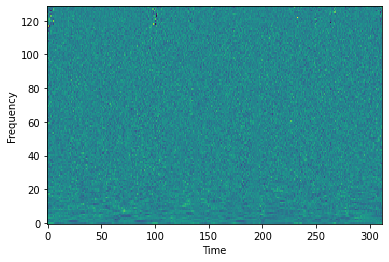

In [13]:
# Plot the spectrogram of the whitened Data
plot_spectrogram(whitened_data)

In [14]:
# Compute the covariance matrix of whitened data
def compute_covariance_matrix(whitened_data):
    whitened_mean_vector = (np.sum(whitened_data,axis=1)*(1.0/whitened_data.shape[1])).reshape((-1,1))
    mean_centered_data = whitened_data - whitened_mean_vector
    covariance_matrix = (1.0/mean_centered_data.shape[1])*(np.matmul(mean_centered_data,mean_centered_data.transpose()))
    return covariance_matrix

# Compute the average of the absolute value of the non diagonal entries in the covariance matrix.
def compute_average_abs_value(cov_matrix): 
    s = 0
    count  = 0
    for i in range(cov_matrix.shape[0]):
        for j in range(cov_matrix.shape[1]):
            if i!=j:
                #print(cov_matrix[i][j])
                count+=1
                s = s + abs(cov_matrix[i][j])
                #print(whitened_noisy_covariance_matrix[i][j])
                
    return s*(1.0/count)


whitenend_clean_covariance = compute_covariance_matrix(whitened_data)
abs_average = compute_average_abs_value(whitenend_clean_covariance)
print("Average of Absolute value of Non Diagonal Entries (Clean) = " + str(abs_average)+" = approx 0 ")


Average of Absolute value of Non Diagonal Entries (Clean) = 4.973985793362607e-15 = approx 0 


### Fit the whitening Transform derived from the clean audio to the noisy audio

3.125


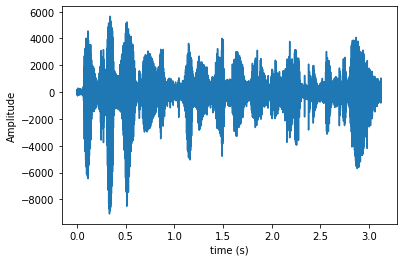

(128, 311)


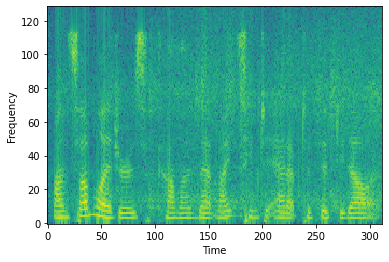

In [15]:
sample_rate,noisy_wav_file = wavfile.read("noisy.wav")
length = len(noisy_wav_file)/sample_rate
print(length)
plot_time_series_graph(noisy_wav_file)
noisy_spectrogram = compute_spectrogram(noisy_wav_file)
plot_spectrogram(noisy_spectrogram)

In [30]:
# Center the noisy data around the mean derived from the clean audio
# Project it on to the principal components and apply whitening

mean_centered_noisy_data = clean_whitening.compute_mean_centered_data(noisy_spectrogram)
projected_noisy_data = clean_whitening.project_data(mean_centered_noisy_data)
whitened_noisy_data = clean_whitening.whiten_data(projected_noisy_data)
print(whitened_noisy_data)

[[  0.30316564   0.32174912   0.35453325 ...  -0.93143227  -0.90962774
   -0.86083398]
 [ -0.86953533  -0.97500661  -0.76479366 ...  -0.73504665  -0.85236682
   -0.95353286]
 [  0.19977106   0.34196563   0.14825623 ...   0.1877354   -0.12396941
   -0.36023595]
 ...
 [ 20.26688026 -11.10998963 -30.59512747 ...   5.37546398  14.73690606
  -23.40950956]
 [-20.72922378  10.00737155  -5.73970416 ... -11.79214617  -2.85947867
  -29.76831637]
 [ 10.12312191   6.87289593  -1.38576135 ... -18.76591738  -8.72090003
    9.72440127]]


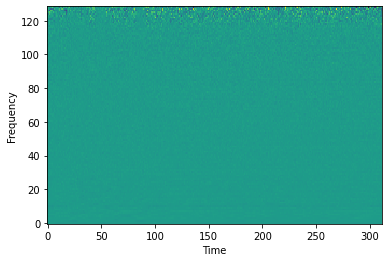

In [17]:
# Whitened noisy data with respect to parameters derived from clean audio
plot_spectrogram(whitened_noisy_data)


In [18]:
whitened_noisy_covariance_matrix = compute_covariance_matrix(whitened_noisy_data)
abs_average_noisy = compute_average_abs_value(whitened_noisy_covariance_matrix)
print("Average of Absolute value of Non Diagonal Entries (Noisy) = " + str(abs_average_noisy))

Average of Absolute value of Non Diagonal Entries (Noisy) = 0.18946791295537385


In [19]:
ans1 = compute_average_abs_value(compute_covariance_matrix(noisy_spectrogram))
ans2 = compute_average_abs_value(compute_covariance_matrix(clean_spectrogram))

print("\nAverage of Absolute value of Non Diagonal Entries (Noisy Non Whitened) = " + str(ans1))
print("Average of Absolute value of Non Diagonal Entries  ( Clean Non Whitened) = " + str(ans2) + "\n\n")


print("Average of Absolute value of Non Diagonal Entries (Noisy  Whitened) = " + str(abs_average_noisy))
print("Average of Absolute value of Non Diagonal Entries (Clean Whitened) = " + str(abs_average)+"= approx 0 \n")


Average of Absolute value of Non Diagonal Entries (Noisy Non Whitened) = 0.19995807389970677
Average of Absolute value of Non Diagonal Entries  ( Clean Non Whitened) = 1.1716414531024484


Average of Absolute value of Non Diagonal Entries (Noisy  Whitened) = 0.18946791295537385
Average of Absolute value of Non Diagonal Entries (Clean Whitened) = 4.973985793362607e-15= approx 0 



The correlation between the dimensions decreases on applying whitening irrespective of whether it is clean or noisy data. The amount by which reduction takes place depends on the distribution from which the parameters of the whitening transformation is derived. Now let us check if it is true when the roles are reversed

## Noisy Data Role Reversal

Perform the same series of steps while reversing the role of noisy and clean data

In [20]:
noisy_whitening = WhiteningTransform()

In [21]:
# Do the same sequence of steps done for computing the covariance matrix for clean audion
mean_noisy_vector =  noisy_whitening.compute_mean(noisy_spectrogram)
mean_centered_noisy_data =  noisy_whitening.compute_mean_centered_data(noisy_spectrogram)
noisy_covariance_matrix = noisy_whitening.compute_covariance_matrix(mean_centered_noisy_data)


In [22]:
# Project the noisy audio data to its principal components and whiten the data
eig_val,eig_vec = noisy_whitening.compute_eigen_values_eigen_vectors(noisy_covariance_matrix)
pca_projected_noisy_data = noisy_whitening.project_data(mean_centered_noisy_data)

whitened_noisy_data = noisy_whitening.whiten_data(pca_projected_noisy_data)



Largest Eigen Value = 26.34964575886783

Eigen Vector corresponding to the largest eigen value

[ 7.84902202e-02  3.47735891e-02  4.51275273e-02  1.26133235e-01
  9.80363362e-02  1.11517620e-01  1.12946935e-01  7.82273042e-02
  5.27297149e-02  8.67145337e-02  6.74258351e-02  4.13704324e-02
  5.94361527e-02  4.41591655e-02  3.96956039e-02  4.09280875e-02
  2.19965134e-02  4.70180810e-02  4.28512196e-02  3.47718323e-02
  4.16924145e-02  4.92557066e-02  2.80746575e-02  3.11836407e-02
  6.85837850e-02  6.00557309e-02  4.72632139e-02  7.10097503e-02
  5.63474846e-02  4.13534357e-02  5.55863556e-02  3.87842647e-02
  1.18702311e-02  9.67791356e-03  1.33269197e-02 -8.74940317e-03
 -1.10607337e-03  6.54953509e-05 -1.02175008e-02 -2.38144073e-02
 -1.83974052e-02 -3.25042430e-02 -1.27410487e-02 -3.04162056e-02
 -2.73996900e-02 -3.88488313e-02 -4.54711966e-02 -3.84657878e-02
 -4.06670620e-02 -4.07805447e-02 -3.03120815e-02 -4.68212989e-02
 -4.67872150e-02 -3.66867433e-02 -5.66297675e-02 -5.217143

In [31]:
print(whitened_noisy_data)

[[  0.30316564   0.32174912   0.35453325 ...  -0.93143227  -0.90962774
   -0.86083398]
 [ -0.86953533  -0.97500661  -0.76479366 ...  -0.73504665  -0.85236682
   -0.95353286]
 [  0.19977106   0.34196563   0.14825623 ...   0.1877354   -0.12396941
   -0.36023595]
 ...
 [ 20.26688026 -11.10998963 -30.59512747 ...   5.37546398  14.73690606
  -23.40950956]
 [-20.72922378  10.00737155  -5.73970416 ... -11.79214617  -2.85947867
  -29.76831637]
 [ 10.12312191   6.87289593  -1.38576135 ... -18.76591738  -8.72090003
    9.72440127]]


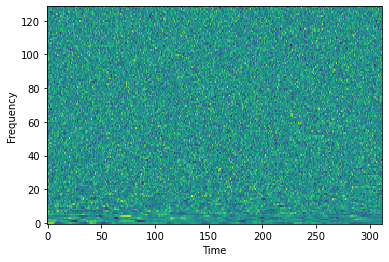

In [24]:
plot_spectrogram(whitened_noisy_data)

In [25]:
# Apply the whitening transformation on the clean audio using parameters derived from the noisy data
mean_centered_clean_data = noisy_whitening.compute_mean_centered_data(clean_spectrogram)
projected_clean_data = noisy_whitening.project_data(mean_centered_clean_data)
whitened_clean_data = noisy_whitening.whiten_data(projected_clean_data)

[[ 6.63407794  6.34095816  6.18158827 ...  2.79090406  4.93312644
   5.35157172]
 [ 5.04582036  5.13600623  4.94298519 ...  3.27105401  5.12461628
   4.55763672]
 [ 2.01322901  2.71730996  3.00870044 ...  1.1675207   0.93941972
   1.13189933]
 ...
 [-3.34981295 -2.30486686 -0.17643427 ... -2.6540575   5.04292852
  -0.12067112]
 [ 3.63177617  3.03788506  2.91915895 ...  0.34515077 -0.38213592
  -0.90263569]
 [ 3.74310762  2.40996716  4.94571532 ... -0.59463781 -0.40363414
  -2.55144628]]


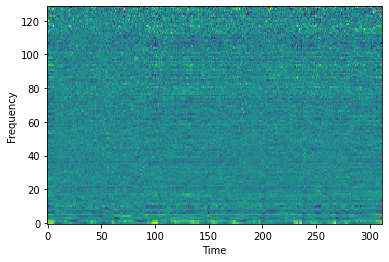

In [32]:
print(whitened_clean_data)
plot_spectrogram(whitened_clean_data)

In [33]:
# Compute the average of the absolute value of the non diagonal entries in the covariance matrix
whitened_clean_covariance_matrix = compute_covariance_matrix(whitened_clean_data)
whitened_clean_abs_cov = compute_average_abs_value(whitened_clean_covariance_matrix)
print("Average of Absolute value of Non Diagonal Entries (Clean) Covariance Matrix = " + str(whitened_clean_abs_cov))

Average of Absolute value of Non Diagonal Entries (Clean) Covariance Matrix = 0.12322900763675562


In [34]:
noisy_whitened_covariance_matrix = compute_covariance_matrix(whitened_noisy_data)
print("Average of Absolute value of Non Diagonal Entries (Noisy) Covariance Matrix= " + str(compute_average_abs_value(noisy_whitened_covariance_matrix))+" = approx 0 ")

Average of Absolute value of Non Diagonal Entries (Noisy) Covariance Matrix= 0.18946791295537385 = approx 0 


In [35]:
ans1 = compute_average_abs_value(compute_covariance_matrix(noisy_spectrogram))
ans2 = compute_average_abs_value(compute_covariance_matrix(clean_spectrogram))

print("\nAverage of Absolute value of Non Diagonal Entries (Noisy Non Whitened) = " + str(ans1))
print("Average of Absolute value of Non Diagonal Entries  ( Clean Non Whitened) = " + str(ans2) + "\n\n")


print("Average of Absolute value of Non Diagonal Entries (Noisy  Whitened) = " + str(compute_average_abs_value(noisy_whitened_covariance_matrix))+" = approx 0 ")
print("Average of Absolute value of Non Diagonal Entries (Clean Whitened) = " + str(whitened_clean_abs_cov)+"\n")



Average of Absolute value of Non Diagonal Entries (Noisy Non Whitened) = 0.19995807389970677
Average of Absolute value of Non Diagonal Entries  ( Clean Non Whitened) = 1.1716414531024484


Average of Absolute value of Non Diagonal Entries (Noisy  Whitened) = 0.18946791295537385 = approx 0 
Average of Absolute value of Non Diagonal Entries (Clean Whitened) = 0.12322900763675562



We see that indeed the correlation between dimensions decrease even after computing the whitening parameters from the noisy data